In [1]:
import sys
print(sys.executable)

sys.path.append('../../')

/home/aag16683ti/100_GQE/200_Minami/gqco_cu118/.env/bin/python


In [2]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from IPython.display import display, Math
from gqco.train import MyModel
from gqco.utils import fix_seed, arange_token
from gqco.data import generate_data
from gqco.solve import solve_from_token, plot_from_dict
from gqco.model import TransformerWithMoE

['/home/aag16683ti/anaconda3/lib/python311.zip', '/home/aag16683ti/anaconda3/lib/python3.11', '/home/aag16683ti/anaconda3/lib/python3.11/lib-dynload', '', '/home/aag16683ti/100_GQE/200_Minami/gqco_cu118/.env/lib/python3.11/site-packages', '/home/aag16683ti/100_GQE/200_Minami/gqco_cu118/']


In [3]:
def data_from_adj(adj, args, num_clone, device):
    dataset = RandomGraphDatasetWithClone(adj, num_clone=num_clone, device=device)
    dataset.x = dataset.x.half()
    dataset.edge_attr = dataset.edge_attr.half()
    record = Batch.from_data_list(dataset)
    record['size'] = record['size'].tolist()[0]
    record['len'] = dataset.len()

    return adj, size, record

In [4]:
task_path = '../../model/taskobjects.pkl'
checkpoint_path = '../../model/merged_model.ckpt'
seed=0

with open(task_path, 'rb') as f: 
    obj = pickle.load(f)
gqco = obj['task']
args = obj['args']

In [5]:
model = TransformerWithMoE(args)
model = MyModel.load_from_checkpoint(checkpoint_path, model=model, task=gqco, args=args)
model = model.to('cuda')
device = model.device

In [28]:
seed=0

0
1
2
3
4
5
-- Token --
[182, 182, 281, 182, 243, 142]


-- Circuit --


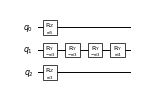



-- Transpiled circuit --


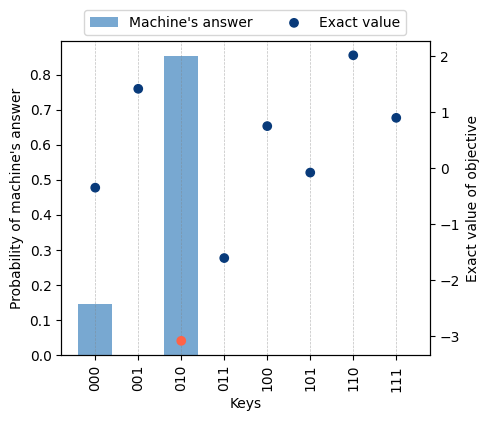

In [58]:
model.eval()

# seed = np.random.randint(1, 10000)
# seed += 1
seed = 42
size = 3

## Generate data
# adj, size, record = generate_data(args, num_clone=20, seed=seed, device=model.device, size=size)
adj, size, record = data_from_adj(adj.to(device), args, 100, device)

fix_seed(seed)

## Generate circuits
with torch.no_grad():
    with torch.autocast('cuda'):
        out_tokens, probs_all, _, logits_all = model.forward(record, temperature=2.0)
tokens_list = [arange_token(t, args) for t in out_tokens.detach().tolist()]
energies = [gqco.compute_energy(t, adj, args.num_shot) for t in tokens_list]

## Get the best
idx_min = energies.index(min(energies))
token_min = tokens_list[idx_min]
energy_min = energies[idx_min]

## Make result
dict_pred, dict_true, qc = solve_from_token(gqco, token_min, adj, is_print=True, savefile=None)
plot_from_dict(dict_pred, dict_true, savefile=None)